In [30]:
import pandas as pd
import numpy as np

import tensorflow as tf

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# TODO

- [ ] PCA and possible dimensionality reduction on the feature space
- [ ] Better scoring metrics for teams - better than the average of all the stuff
- [ ] Use the epl-full-training dataset - currently using the provided one


## Load data

In [31]:
df = pd.read_csv('./data/epl-training.csv')

In [32]:
print(df.shape)
df.head()

(8486, 22)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,19/08/00,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,19/08/00,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,19/08/00,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,19/08/00,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


Convert time to datetime format, create a 'trivial' df.

In [33]:
df_trivial = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR']]
df_trivial['Date'] = pd.to_datetime(df_trivial['Date'])


/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_18346/3299586933.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_trivial['Date'] = pd.to_datetime(df_trivial['Date'])
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_18346/3299586933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trivial['Date'] = pd.to_datetime(df_trivial['Date'])


Add separate date features and drop unconverted Date.

In [34]:
df_trivial['Day'] = df_trivial['Date'].dt.day
df_trivial['Month'] = df_trivial['Date'].dt.month
df_trivial['Year'] = df_trivial['Date'].dt.year - 2000
df_trivial = df_trivial.drop(columns=['Date'])

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_18346/3321928094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trivial['Day'] = df_trivial['Date'].dt.day
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_18346/3321928094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trivial['Month'] = df_trivial['Date'].dt.month
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_18346/3321928094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [35]:
df_trivial.head()

,HomeTeam,AwayTeam,FTR,Day,Month,Year
0,Charlton,Man City,H,19,8,0
1,Chelsea,West Ham,H,19,8,0
2,Coventry,Middlesbrough,A,19,8,0
3,Derby,Southampton,D,19,8,0
4,Leeds,Everton,H,19,8,0


#### Plot histogram of wins/loses/draws

<AxesSubplot: >

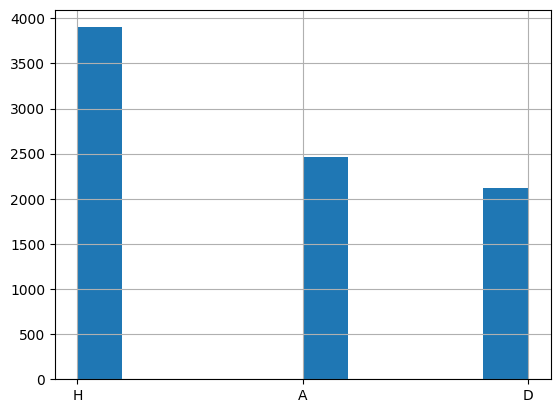

In [36]:
df['FTR'].hist()

## Create team average statistics

Dropping the referee, we don't need the guy....

In [37]:
df = df.drop(columns=['Referee'])

Calculate the averages, store them in other DFs.

In [38]:
home_teams = list(df['HomeTeam'].unique())
away_teams = list(df['AwayTeam'].unique())
home_teams_df = pd.DataFrame()
away_teams_df = pd.DataFrame()
for team in home_teams:
    df_tmp = df[df['HomeTeam'] == team].mean(numeric_only=True).to_frame(team).transpose()
    df_tmp['Team'] = [team]

    home_teams_df = pd.concat([home_teams_df, df_tmp])

for team in away_teams:
    df_tmp = df[df['AwayTeam'] == team].mean(numeric_only=True).to_frame(team).transpose()
    df_tmp['Team'] = [team]

    away_teams_df = pd.concat([away_teams_df, df_tmp])

Renaming columns in those DFs.

In [39]:
home_teams_df = home_teams_df.rename(columns=dict(zip(list(home_teams_df.columns), list(map(lambda x: "Home"+x, home_teams_df.columns)))))
away_teams_df = away_teams_df.rename(columns=dict(zip(list(away_teams_df.columns), list(map(lambda x: "Away"+x, away_teams_df.columns)))))

In [40]:
home_teams_df.head()

,HomeFTHG,HomeFTAG,HomeHTHG,HomeHTAG,HomeHS,HomeAS,HomeHST,HomeAST,HomeHC,HomeAC,HomeHF,HomeAF,HomeHY,HomeAY,HomeHR,HomeAR,HomeTeam
Charlton,1.345865,1.338346,0.646617,0.533835,10.796992,11.669173,5.804511,6.172932,5.496241,6.090226,12.323308,12.714286,1.187970,1.556391,0.097744,0.060150,Charlton
Chelsea,2.085106,0.810875,0.981087,0.328605,16.342790,8.316785,7.529551,3.569740,6.765957,3.869976,10.825059,12.193853,1.338061,1.808511,0.059102,0.092199,Chelsea
Coventry,0.736842,1.210526,0.421053,0.578947,11.210526,10.947368,5.000000,5.526316,6.684211,5.789474,13.000000,15.000000,1.315789,1.526316,0.157895,0.000000,Coventry
Derby,0.964912,1.631579,0.473684,0.543860,9.403509,11.789474,4.508772,6.122807,4.701754,5.771930,13.491228,13.578947,1.701754,1.578947,0.035088,0.035088,Derby
Leeds,1.433333,1.366667,0.641667,0.633333,13.541667,11.791667,5.750000,5.350000,6.241667,4.825000,13.983333,13.266667,1.791667,1.816667,0.058333,0.050000,Leeds


Sneaky joins to include home and away teams' average statistics for each match sample.

In [ ]:
df_average = df_trivial.join(home_teams_df, 'HomeTeam', lsuffix='_caller', rsuffix='_other')
df_average = df_average.join(away_teams_df, 'AwayTeam', lsuffix='_caller', rsuffix='_other')

Cleaning after not-so-sneaky joins...

In [ ]:
df_average = df_average.drop(columns=['AwayTeam_other', "HomeTeam_other"])
df_average = df_average.rename(columns={
    'HomeTeam_caller': 'HomeTeam',
    "AwayTeam_caller": 'AwayTeam'
})

## Classification

**Select df to be used for model training and testing.**

In [ ]:
# df_for_models = df_trivial
df_for_models = df_average

### Categorical + Label Encodings

Encode team names and FTR.

In [ ]:
oe = OrdinalEncoder()
le = LabelEncoder()

df_for_models[['HomeTeamCode', 'AwayTeamCode']] = oe.fit_transform(df_for_models[['HomeTeam', 'AwayTeam']])
df_for_models['FTRCode'] = le.fit_transform(df_for_models['FTR'])

Label mapping

In [ ]:
le.classes_, le.transform(le.classes_)

(array(['A', 'D', 'H'], dtype=object), array([0, 1, 2]))

Drop unused columns with not converted date, unencoded team names and unencoded FTR.

In [ ]:
df_for_models = df_for_models.drop(columns=['HomeTeam', 'AwayTeam', 'FTR'])

### Data Split & Normalization

Create X, Y numpy objects.

In [ ]:
X, Y = df_for_models.drop(columns='FTRCode').to_numpy(), df_for_models['FTRCode'].to_numpy()

Normalize values in X.

In [ ]:
ss = StandardScaler()
X = ss.fit_transform(X)

Perform the data split.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Simple ensemble model - Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy 0.4787985865724382


/Users/aszab/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


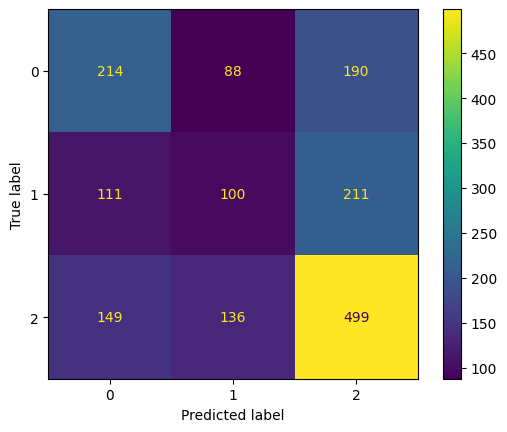

In [ ]:
y_preds = rfc.predict(x_test)
print("Accuracy", accuracy_score(y_test, y_preds))
plot_confusion_matrix(rfc, x_test, y_test)

### A bit more interesting Boosting

In [ ]:
xgb = XGBClassifier(n_estimators=100, max_depth=100, random_state=42)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=100, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

Accuracy 0.5041224970553593


/Users/aszab/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


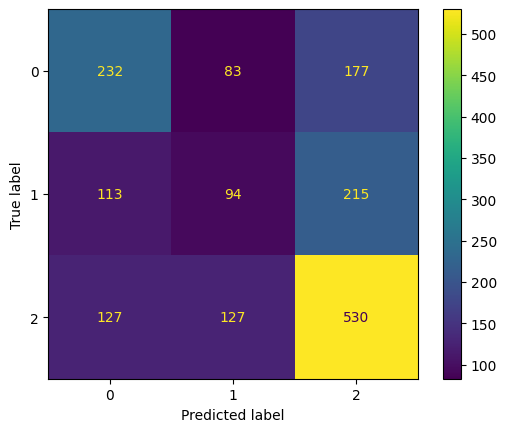

In [ ]:
y_preds = xgb.predict(x_test)
print("Accuracy", accuracy_score(y_test, y_preds))
plot_confusion_matrix(xgb, x_test, y_test)

### Let's go! - Vanilla NN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X.shape[1], activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-18 23:41:47.932811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 23:41:47.932957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10


2022-11-18 23:41:48.046949: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/213 [..............................] - ETA: 1:26 - loss: 1.1642 - accuracy: 0.2812

2022-11-18 23:41:48.310478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


213/213 [==============================] - 2s 6ms/step - loss: 1.0046 - accuracy: 0.5137
Epoch 2/10
213/213 [==============================] - 1s 6ms/step - loss: 0.9851 - accuracy: 0.5264
Epoch 3/10
213/213 [==============================] - 1s 6ms/step - loss: 0.9766 - accuracy: 0.5308
Epoch 4/10
213/213 [==============================] - 2s 7ms/step - loss: 0.9680 - accuracy: 0.5349
Epoch 5/10
213/213 [==============================] - 1s 7ms/step - loss: 0.9589 - accuracy: 0.5407
Epoch 6/10
213/213 [==============================] - 1s 6ms/step - loss: 0.9468 - accuracy: 0.5523
Epoch 7/10
213/213 [==============================] - 1s 6ms/step - loss: 0.9372 - accuracy: 0.5524
Epoch 8/10
213/213 [==============================] - 1s 7ms/step - loss: 0.9247 - accuracy: 0.5597
Epoch 9/10
213/213 [==============================] - 1s 6ms/step - loss: 0.9117 - accuracy: 0.5772
Epoch 10/10
213/213 [==============================] - 1s 6ms/step - loss: 0.8972 - accuracy: 0.5863


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

2022-11-18 23:42:02.546845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 - 0s - loss: 1.0175 - accuracy: 0.5112 - 348ms/epoch - 6ms/step


54/54 [==============================] - 0s 2ms/step


2022-11-18 23:42:02.916354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


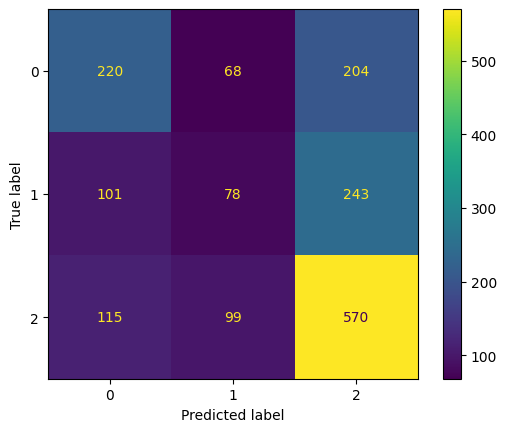

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(
        y_test,
        tf.argmax(model.predict(x_test), axis=1)
    )
).plot()